# Term Deposit Predictions
Jacob Macdonald
### Problem Definition
Term deposits are an important mechanism for banks to receive funds they can use in other investments with higher rates of return. Thus, it is of great interest for banks to better understand what factors may contribute to customers deciding to subscribe to a term deposit. In this case study, I developed models describing the relationship between a variety of factors from directed marketing campaigns for term deposits and the likelihood of the targets in question subscribing to a term deposit.
### Data Set
The provided data set was derived from direct marketing campaigns for term deposits of a Portuguese banking institution from May 2008 to November 2010. The marketing campaigns were conducted over the phone, both actively calling a list of clients to sell the deposit and soliciting client calls to the contact center for any other reason. The data set can be downloaded from [UC Irvine's Machine Learning Respository](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) and was published in the [Decision Support Systems Journal](https://www.sciencedirect.com/science/article/pii/S016792361400061X).

In [1]:
# Importing useful Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# The grid search model selection process occasionally resulted in parameters that were divided by 0, throwing warnings.
# These warning were suppressed for enhanced readability following finalization of all code.
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading in the data sets
bank_full = pd.read_csv("bank-additional-full.csv", sep=";") #Full data set
bank_partial = pd.read_csv("bank-additional.csv", sep=";") # Data set with 10% of cases (same features as full data set)

In [3]:
# Confirming correct file import
bank_full.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Model Strategy
For model development, I will focus on the partial data set with 10% of the values. This will allow for easier testing of computationally demanding machine learning algorithms. A variety of classification machine learning algorithms will be investigated, including logistic regression, random forests, and SVM.

### Data Cleaning
First and foremost, let's convert the results column "y" from "yes" or "no" to the binary outcomes of 1 or 0, respectively.

In [4]:
bank_partial["y"] = bank_partial["y"].replace(["yes","no"],[1,0])

The feature columns need to be cleaned for a variety of factors that could confound the developed models, including:
1. Leaking information from the future
2. Poor formatting
3. Containing redundant data
4. Missing data or needing more processing to be useful

Before cleaning any features, however, let's first remove any duplicate rows from the data set.

In [5]:
print("Number of rows before duplicate removal: ", bank_partial.shape[0])
n_duplicates = bank_partial.duplicated().sum()
print("Number of duplicates: ",n_duplicates)
bank_partial = bank_partial.drop_duplicates()
print("Number of rows after duplicate removal: ",bank_partial.shape[0])

Number of rows before duplicate removal:  4119
Number of duplicates:  0
Number of rows after duplicate removal:  4119


#### Leaking Information from the Future
The aim is to develop a model that will help banking institutions determine clients who will be receptive to term deposit marketing campaigns **in advance**. Thus, features should be omitted if they include information we could not realistically control for future campaigns. Including these in our model could lead to overfitting. Referring to the data dictionary for this data set reveal a few features that should be excluded for this reason.
* "duration": Call duration cannot be controlled in advance.
* "campaign": It cannot be predicted in advance how many contacts will be performed for a particular person during the campaign.

In [6]:
# Removing these two features from our data set.
bank_partial = bank_partial.drop(['duration','campaign'], axis=1)

#### Poor Formatting
Inspection of the features reveals that this data set has consistent formatting for each category. Thus, no cleaning needs to be done in this respect.

#### Containing Redundant Data
The features "pdays", "previous", and "poutcome" seem to have redundant data. If we include this information and there is a correlation between clients not previously being contacted and willingness to subscribe to a term deposit, the model may overfit on this relationship given its representation in all three of these features. For simplicity, let's only keep one. We will keep "poutcome" because it is most directly relevant to the goal of predicting how amenable a client will be to subscribing to a service.

In [7]:
bank_partial["pdays"].value_counts()

999    3959
3        52
6        42
4        14
7        10
10        8
12        5
5         4
2         4
9         3
1         3
13        2
18        2
16        2
15        2
0         2
14        1
19        1
21        1
17        1
11        1
Name: pdays, dtype: int64

In [8]:
bank_partial["previous"].value_counts()

0    3523
1     475
2      78
3      25
4      14
6       2
5       2
Name: previous, dtype: int64

In [9]:
bank_partial["poutcome"].value_counts()

nonexistent    3523
failure         454
success         142
Name: poutcome, dtype: int64

In [10]:
# Removing the redundant features from our data set.
bank_partial = bank_partial.drop(['pdays','previous'], axis=1)

#### Missing Data or Needing More Processing to be Useful
For this step it is important to remember that missing values in this data set do not appear as NaN, but as the text field "unknown." Approaching this on a feature-by-feature basis:

*Age:* Currently there are 67 unique values for age, ranging from 18 to 88. We will standardize this parameter. This will be done later in the notebook with the economic indicators.

In [11]:
bank_partial["age"].describe()

count    4119.000000
mean       40.113620
std        10.313362
min        18.000000
25%        32.000000
50%        38.000000
75%        47.000000
max        88.000000
Name: age, dtype: float64

*Job:* This feature is a categorical variable with 12 categories (including the unknown column). In the context of this work, we are trying to develop a model to accurately predict who will subscribe to term deposits. A bank will likely have employment information on their own customers, so let's remove the rows with "unknown" values since the bank is unlikely to target these in a future campaign.

In [12]:
bank_partial["job"].value_counts()

admin.           1012
blue-collar       884
technician        691
services          393
management        324
retired           166
self-employed     159
entrepreneur      148
unemployed        111
housemaid         110
student            82
unknown            39
Name: job, dtype: int64

In [13]:
bank_partial = bank_partial[bank_partial["job"] != "unknown"]

*Marital:* This is another categorical feature with 4 values, including the missing values labelled "unknown." As with the previous feature, the missing values comprise a miniscule portion of the data and cannot be adequately inferred. Since the bank would have marriage information on customers it would target with its next campaign, let's remove these unknown values to avoid introducing possible variance into the model with imputation.

In [14]:
bank_partial["marital"].value_counts()

married     2481
single      1144
divorced     444
unknown       11
Name: marital, dtype: int64

In [15]:
bank_partial = bank_partial[bank_partial["marital"] != "unknown"]

*Education:* Another categorical feature with 8 values, including the missing field. This time, the missing field has a non-insignificant number of entries, which suggests we could lose some valuable information if we remove it. In previous studies it has been shown people are likely to not respond to questions or leave them blank if they feel embarassed by their answer or there is not an appropriate category for their answer. With this in mind, let's assume the unknown values correspond to a group who did not receive any formal education. Let's group them with the single illiterate subject in a new "uneducated" group.

In [16]:
bank_partial["education"].value_counts()

university.degree      1256
high.school             912
basic.9y                568
professional.course     533
basic.4y                418
basic.6y                227
unknown                 154
illiterate                1
Name: education, dtype: int64

In [17]:
bank_partial["education"] = bank_partial["education"].replace(["unknown","illiterate"],"uneducated")
bank_partial["education"].value_counts()

university.degree      1256
high.school             912
basic.9y                568
professional.course     533
basic.4y                418
basic.6y                227
uneducated              155
Name: education, dtype: int64

In [18]:
# Pivot table to see how subscription rates vary with education level
pd.pivot_table(bank_partial,values="y",index="education").sort_values("y")

,y
education,
basic.9y,0.073944
basic.6y,0.074890
basic.4y,0.088517
high.school,0.106360
professional.course,0.121951
university.degree,0.130573
uneducated,0.154839


Surprisingly, while proportion subscribed to term deposits is almost directly correlated to education level, our "uneducated" column has the highest rate of subscription to term deposits. This does not necessarily mean our assumption of grouping these values together was incorrect, but it's possible our label is not accurate. On the other hand, if a primary reason for skipping formal education is to immediately go to work in a family trade (such as farming), it may not be surprising that this group has the financial freedom to subscribe to a term deposit.

*After development, the models were run with all 'unknown' values in the education feature removed. It was found this resulted in worse model performance.*

*Default:* This parameter was a yes/no binary outcome. However, there is only 1 yes response and many unknowns. The lack of variance in the known values, and large amount of unknowns, suggest this parameter will not be useful to our model. Let's remove this entire feature.

In [19]:
bank_partial["default"].value_counts()

no         3284
unknown     784
yes           1
Name: default, dtype: int64

In [20]:
bank_partial = bank_partial.drop("default",axis=1)

*Housing:* The housing feature is a binary yes/no variable with 105 missing responses. It appears that the following "Loan" feature is missing responses from the same 105 respondants. Let's eliminate these variables, to improve the predictive power of the model when the bank can select who they target based on having all information available. With the missing values removed, we can convert this from "yes"/"no" to a binary 1/0.

In [21]:
bank_partial["housing"].value_counts()

yes        2148
no         1816
unknown     105
Name: housing, dtype: int64

In [22]:
bank_partial["loan"].value_counts()

no         3308
yes         656
unknown     105
Name: loan, dtype: int64

In [23]:
bank_partial = bank_partial[bank_partial["housing"] != "unknown"]
bank_partial["housing"] = bank_partial["housing"].replace(["yes","no"],[1,0])

*Loan:* With the cases having missing values for "housing" removed, there are no remaining missing values for "loan". Let's convert this from a binary "yes"/"no" to 1/0.

In [24]:
bank_partial["loan"] = bank_partial["loan"].replace(["yes","no"],[1,0])

*Contact:* This binary outcome variable will be changed from cellular/telephone to 1/0 to accomodate models that don't support mixed data types.

In [25]:
bank_partial["contact"].value_counts()

cellular     2562
telephone    1402
Name: contact, dtype: int64

In [26]:
bank_partial["contact"] = bank_partial["contact"].replace(["cellular","telephone"],[1,0])

*Month:* This a difficult feature as we are missing data for January and February. It appears that the campaign did not run in these months. The large volume of calls over the summer months, shown below, suggests that this is when most of the campaigning was done. However, looking at the bar plot below suggests subscription rates were significantly higher in the months with much fewer clients contacted. This may suggest that the summer saw targeted outgoing calls, where in the winter months they advertised only to customers that called in. Unfortunately, it is impossible to distinguish between these two forms of contact with the current data set. For now, we'll leave this parameter in our model, but it might be best to exclude given this imbalance and lack of knowledge on the data collection parameters.

*Following model development, running the models without the month feature resulted in worse performance.*

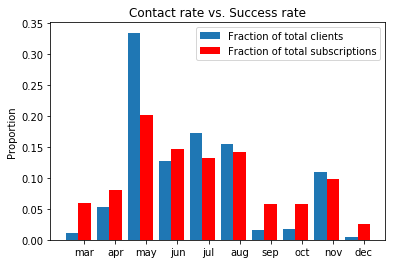

In [27]:
# Ordering the 'month' feature by chronological month order
months = bank_partial["month"].value_counts()
labels = ["mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
months = months[labels]
#sales_rate = pd.pivot_table(bank_partial,values="y",index="month").loc[labels]["y"]
sales_count = pd.pivot_table(bank_partial,values="y",index="month",aggfunc=sum).loc[labels]["y"]

barWidth = 0.4
x1 = np.arange(len(labels))
x2 = [x + barWidth for x in x1]

# Plotting fraction of total calls vs fraction of total subscriptions by month
plt.bar(x1,months/months.sum(),width=barWidth,label='Fraction of total clients')
plt.bar(x2,sales_count/sales_count.sum(),width=barWidth,color='red',label='Fraction of total subscriptions')
plt.xticks([r+barWidth for r in range(len(labels))], labels)
plt.ylabel('Proportion')
plt.title('Contact rate vs. Success rate')
plt.legend()

*Day of week:* The days on which clients were contacted and the proportion of which agreed to term deposits were approximately uniform distributions. These won't contribute much to our model, and thus, this feature is being omitted for efficiency.

*After model development, this parameter was included to assess impact on performance. Inclusion of this parameter resulted in worse model performance, as predicted, and was thus left omitted from the final model.*

In [28]:
bank_partial["day_of_week"].value_counts()

mon    826
thu    824
tue    804
wed    771
fri    739
Name: day_of_week, dtype: int64

In [29]:
# Pivot table to show subscription rates by day of week
pd.pivot_table(bank_partial,values="y",index="day_of_week")

,y
day_of_week,
fri,0.110961
mon,0.118644
thu,0.108010
tue,0.109453
wed,0.103761


In [30]:
bank_partial = bank_partial.drop("day_of_week", axis=1)

*emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed:* These five economic indices will be included because they all characterize different aspects of the economy, which has singificant influence on consumer willingness to subscribe to term deposits. All will be standardized (along with the 'age' feature) using a Standard Scaler.

In [31]:
# Scaling our continuous, numerical data with a Standard Scaler
from sklearn.preprocessing import StandardScaler
scale_features = ["age","emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
scaler = StandardScaler()
scaler.fit(bank_partial[scale_features].astype('float64'))
bank_partial[scale_features] = scaler.transform(bank_partial[scale_features])

# Confirm scaling on variables
bank_partial.head()

,age,job,marital,education,housing,loan,contact,month,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,-0.975467,blue-collar,married,basic.9y,1,0,1,may,nonexistent,-1.202374,-1.178963,-1.231754,-1.326774,-0.910606,0
1,-0.102524,services,single,high.school,0,0,0,may,nonexistent,0.653602,0.717707,0.894988,0.715234,0.335597,0
2,-1.460436,services,married,high.school,1,0,0,jun,nonexistent,0.845600,1.529089,-0.276891,0.776921,0.838688,0
4,0.673426,admin.,married,university.degree,1,0,1,nov,nonexistent,-0.114388,-0.650101,-0.320293,0.332430,0.400687,0
5,-0.781480,services,single,university.degree,0,0,1,sep,failure,-0.754380,1.070856,0.656272,-1.574098,-2.748042,0


With our feature columns cleaned and refined, the last step before model development was to convert categorical columns into numerical columns with dummy variables. The columns we need to transform are "job", "marital", "education", "month", and "poutcome". For all of these features except for "month" we will generate k-1 dummies. "month" will receive k dummies because we do not wish to confuse the kth month with January or February, which are absent in our model.

In [32]:
# Creating k-1 dummies for categorical variables and replacing original columns
dummy_df = pd.get_dummies(bank_partial[["job","marital","education","poutcome"]],drop_first=True)
bank_partial = pd.concat([bank_partial, dummy_df], axis=1)
bank_partial = bank_partial.drop(["job","marital","education","poutcome"], axis=1)

# Creating k dummies for 'month' given its missing Jan. and Feb. data
dummy_df = pd.get_dummies(bank_partial["month"])
bank_partial = pd.concat([bank_partial, dummy_df], axis=1)
bank_partial = bank_partial.drop(["month"], axis=1)

# Confirm complete data cleaning and feature transformation
bank_partial.head(10)

,age,housing,loan,contact,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,apr,aug,dec,jul,jun,mar,may,nov,oct,sep
0,-0.975467,1,0,1,-1.202374,-1.178963,-1.231754,-1.326774,-0.910606,0,...,0,0,0,0,0,0,1,0,0,0
1,-0.102524,0,0,0,0.653602,0.717707,0.894988,0.715234,0.335597,0,...,0,0,0,0,0,0,1,0,0,0
2,-1.460436,1,0,0,0.845600,1.529089,-0.276891,0.776921,0.838688,0,...,0,0,0,0,1,0,0,0,0,0
4,0.673426,1,0,1,-0.114388,-0.650101,-0.320293,0.332430,0.400687,0,...,0,0,0,0,0,0,0,1,0,0
5,-0.781480,0,0,1,-0.754380,1.070856,0.656272,-1.574098,-2.748042,0,...,0,0,0,0,0,0,0,0,0,1
6,-0.781480,1,0,1,-0.754380,1.070856,0.656272,-1.576980,-2.748042,0,...,0,0,0,0,0,0,0,0,0,1
7,0.091464,1,0,1,-0.114388,-0.650101,-0.320293,0.332430,0.400687,0,...,0,0,0,0,0,0,0,1,0,0
8,-0.878474,0,0,1,-0.114388,-0.650101,-0.320293,0.310522,0.400687,0,...,0,0,0,0,0,0,0,1,0,0
9,-0.490499,0,0,0,0.653602,0.717707,0.894988,0.715234,0.335597,0,...,0,0,0,0,0,0,1,0,0,0
10,-1.460436,1,0,1,0.845600,0.586783,-0.472204,0.774615,0.838688,0,...,0,0,0,1,0,0,0,0,0,0


### Model Development
Now that the features are cleaned and refined, we are ready to implement our models. In absence of a proper, separate test set of data, we will hold out a portion of the data for later model testing. These will be the last 600 points of our data set (approximately 15% of the total data). We are using the last 600 points instead of a random subset given the time dependence of this data. 

In [33]:
# Importing relevant machine learning classes and functions from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, precision_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [34]:
# Let's break up our data into a training set and a validation set which will be set aside for later. We'll reserve 600 rows for testing.
bank_partial.shape

(3964, 40)

In [35]:
train_group = bank_partial.iloc[:3364,:] # This will be further split into training and validation sets for cross-validation
holdout_group = bank_partial.iloc[3364:,:]  # To be withheld until the models have been trained and cross-validated

### Cross-Validation and Best Model Identification
Propensity for subscription to term deposits may change over time, so it would be inappropriate to randomly subdivide the training data for k-folds cross-validation, which assumes all cases are independent. Instead, we will look at two separate time series cross-validation approaches so our model can characterize the impact of previous economic trends on current willingness to subscribe to a term deposit. For both approaches, the training data was sub-divided into 5 training sets. This number was selected to allow each validation set to span a range longer than 3 months. Two of the economic indicators (emp.var.rate and nr.employed) were quarterly indices, so allowing the validation set to span multiple values of these parameters introduced needed variation for more robust model development.

The first approach investigated was a sliding window approach, where the training set only included the 1000 cases immediately prior to the beginning of the validation set. This approach likely makes the model more sensitive to short term economic effects but blind to long-term effects. The training and validation sets for this approach are visualized below.

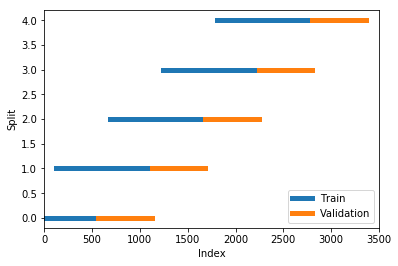

In [36]:
# Max train size defined to incorporate sliding window
tss = TimeSeriesSplit(n_splits=5, max_train_size=1000)
i=0

# Visualizing the train and validation splits for the sliding window approach
for train_index, test_index in tss.split(train_group):  
    plt.plot(train_index,train_index-train_index+i, color='tab:blue', lw=5, label="Train")
    plt.plot(test_index,test_index-test_index+i, color='tab:orange', lw=5, label="Validation")
    plt.xlim([0,3500])
    plt.xlabel('Index')
    plt.ylabel('Split')
    if i==0:
        plt.legend(loc='lower right')
    i += 1

The second approach investigated was an expanding window approach, where the training set continually grew with each split to include all training data from previous splits. This approach may perform better at incorporating long-term economic trends. The training and validation sets for this approach are visualized below.

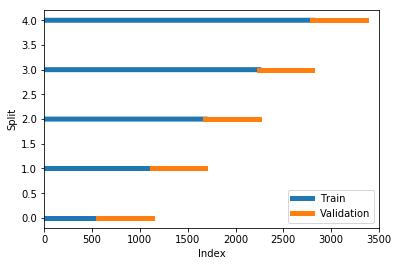

In [37]:
# Max train size has been excluded to allow for expanding training window with each split
tss = TimeSeriesSplit(n_splits=5)
i=0

# Visualizing the train and validation splits for the expanding window approach
for train_index, test_index in tss.split(train_group):  
    plt.plot(train_index,train_index-train_index+i, color='tab:blue', lw=5, label="Train")
    plt.plot(test_index,test_index-test_index+i, color='tab:orange', lw=5, label="Validation")
    plt.xlim([0,3500])
    plt.xlabel('Index')
    plt.ylabel('Split')
    if i==0:
        plt.legend(loc='lower right')
    i += 1

For the sake of brevity and code efficiency, the comparison of performance between these two approaches is not included here. When compared, the expanding window approach obtained slightly higher scores than the sliding window approach, so that is the cross-validation approach that will be used for the forthcoming models.

With our data splits established, we are ready to begin training models. A function was written to support cross-validation of multiple machine learning models for a supplied dataframe. Optimal models were found for logistic regression, neural networks, random forests, and SVMs. Optimal models were defined as those with the highest F1 score. F1 score was selected as the metric because it emphasizes models with both high precision and recall. For this predicative application, a high precision is desired to maximize efficiency of customer targeting. At the same time, we desire good recall to maximize the number of willing clients our model will identify.

On top of these factors, other traditional scoring metrics such as accuracy or AUC for ROC are less useful when dealing with imbalanced data sets such as this one.

In [38]:
# Indicate relevant dependent and target features for modeling.
features = list(train_group.columns.drop("y"))
target = "y"

In [39]:
# Occasionally the grid search will test out model parameters that results in an F1 score of 'nan'. These warnings are supressed here.
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# Function that accepts data frame, desired features, and target variable and performs cross-validation for
# logistic regression, neural network, random forests, and SVM machine learning models.
def select_models(df,features,target):

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"],
                    "class_weight": [None,"balanced"],
                    "max_iter": [1000],
                    "warm_start": [True,False]
                }
        },
        {
            "name": "MLPClassifier",
            "estimator": MLPClassifier(),
            "hyperparameters":
                {
                    "hidden_layer_sizes": [(10,),(10,10),(20,)],
                    "max_iter": [10000],
                    "warm_start": [True,False]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(),
            "hyperparameters":
                {
                    "n_estimators": [10, 20, 30],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5],
                    "warm_start": [True,False]
                }
        },
        {
            "name": "SVC",
            "estimator": SVC(),
            "hyperparameters":
                {
                    "kernel": ["linear","poly","rbf","sigmoid"],
                    "gamma": ['auto','scale'],
                    "class_weight": [None,"balanced"],
                }
        }
    ]

    # Returns relevant information for each best-performing model
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            scoring=['f1','roc_auc','average_precision'],
                            refit='f1',
                            cv=tss.split(df))
        grid.fit(df[features],df[target])
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        model["average_precision"] = grid.cv_results_['mean_test_average_precision'][np.argmax(grid.cv_results_['mean_test_f1'])]
        model["roc_auc"] = grid.cv_results_['mean_test_roc_auc'][np.argmax(grid.cv_results_['mean_test_f1'])]

        print("Best Model F1: {}".format(model["best_score"]))
        print("Best Model Average Precision: {}".format(model["average_precision"]))
        print("Best Model ROC AUC: {}".format(model["roc_auc"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

To address the imbalanced output variable groups (only 10% of clients subscribed to a term deposit), models were developed for three variations of the data set:

1. The original, imbalanced groups. No further alterations were made to the training set.
2. A downsampled majority class (non-subscribers) to have the same number of clients as the minority class (subscribers). Majority class members were randomly deleted from the training set.
3. An upsampled minority class (subscribers) to have the same number of clients as the majority class (non-subscribers). Minority class members were randomly sampled with replacement in the training set.

In [40]:
# Find best models for imbalanced groups
models = select_models(train_group, features, target)

LogisticRegression
------------------
Best Model F1: 0.4045837505315485
Best Model Average Precision: 0.37606857783921155
Best Model ROC AUC: 0.730459834385954
Best Parameters: {'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'liblinear', 'warm_start': True}

MLPClassifier
-------------
Best Model F1: 0.32296023587428496
Best Model Average Precision: 0.30403366569539636
Best Model ROC AUC: 0.622886102692685
Best Parameters: {'hidden_layer_sizes': (10, 10), 'max_iter': 10000, 'warm_start': False}

RandomForestClassifier
----------------------
Best Model F1: 0.32639029399378133
Best Model Average Precision: 0.3877974394476363
Best Model ROC AUC: 0.7254175912679937
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10, 'warm_start': False}

SVC
---
Best Model F1: 0.45658118875793047
Best Model Average Precision: 0.361223951571635
Best Model ROC AUC: 0.7486621484393614
Best Parameters: {'cla

In [41]:
# Finding the best models when undersampling the majority class
from sklearn.utils import resample

train_subscribe = train_group[train_group["y"] == 1]
train_not_subscribe = train_group[train_group["y"] == 0]
not_subscribe_downsampled = resample(train_not_subscribe,
                               replace=False,
                               n_samples=len(train_subscribe) # match number in minority class
                              )
train_downsampled = pd.concat([not_subscribe_downsampled,train_subscribe])
# Sort by index to return to chronological order
train_downsampled = train_downsampled.sort_index()

In [42]:
models_downsampled = select_models(train_downsampled, features, target)

LogisticRegression
------------------
Best Model F1: 0.6449862970729222
Best Model Average Precision: 0.7730018494522982
Best Model ROC AUC: 0.7251742755950059
Best Parameters: {'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'liblinear', 'warm_start': True}

MLPClassifier
-------------
Best Model F1: 0.6180664170931649
Best Model Average Precision: 0.7144483216288877
Best Model ROC AUC: 0.6790240790586151
Best Parameters: {'hidden_layer_sizes': (10, 10), 'max_iter': 10000, 'warm_start': False}

RandomForestClassifier
----------------------
Best Model F1: 0.6736750152782794
Best Model Average Precision: 0.7493251229316694
Best Model ROC AUC: 0.742557378976474
Best Parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10, 'warm_start': True}

SVC
---
Best Model F1: 0.6745019765118616
Best Model Average Precision: 0.7805110564648441
Best Model ROC AUC: 0.7387919942693825
Best Parameters: {'class

In [43]:
# Finding the best models when upsampling the minority class
from sklearn.utils import resample

subscribe_upsampled = resample(train_subscribe,
                               replace=True,
                               n_samples=len(train_not_subscribe) # match number in minority class
                              )
train_upsampled = pd.concat([subscribe_upsampled,train_not_subscribe])
# Sort by index to return to chronological order
train_upsampled = train_upsampled.sort_index()

In [44]:
models_upsampled = select_models(train_upsampled, features, target)

LogisticRegression
------------------
Best Model F1: 0.6341053743869519
Best Model Average Precision: 0.756597018662392
Best Model ROC AUC: 0.7219020771900491
Best Parameters: {'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'newton-cg', 'warm_start': True}

MLPClassifier
-------------
Best Model F1: 0.4898922631985374
Best Model Average Precision: 0.6918702887077824
Best Model ROC AUC: 0.6497611533229085
Best Parameters: {'hidden_layer_sizes': (10,), 'max_iter': 10000, 'warm_start': False}

RandomForestClassifier
----------------------
Best Model F1: 0.6643493676971861
Best Model Average Precision: 0.7690679170059124
Best Model ROC AUC: 0.7421699288662049
Best Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 10, 'warm_start': False}

SVC
---
Best Model F1: 0.6383701337945261
Best Model Average Precision: 0.76110822677627
Best Model ROC AUC: 0.7270889409104969
Best Parameters: {'class_weight

The resampled data sets resulted in higher F1 scores than the unbalanced data sets.

### Applying the Best Models to the Holdout Data
To efficiently compare the performance of each sampling method on the held out test data, the top performing model for each sampling method was applied to the data. ROC curves and Precision-Recall curves were generated for each of these cases.

In [45]:
# Best model: Uneven groups
prediction = models[3]["best_model"].decision_function(holdout_group[features])
fpr,tpr,thresholds = roc_curve(holdout_group[target],prediction)
auc = roc_auc_score(holdout_group[target],prediction)
precision,recall,thresholds2 = precision_recall_curve(holdout_group[target],prediction)
avg_prec = average_precision_score(holdout_group[target],prediction)

# Best model: Downsampled minority group
down_prediction = models_downsampled[3]["best_model"].decision_function(holdout_group[features])
down_fpr,down_tpr,down_thresholds = roc_curve(holdout_group[target],down_prediction)
down_auc = roc_auc_score(holdout_group[target],down_prediction)
down_precision,down_recall,down_thresholds2 = precision_recall_curve(holdout_group[target],down_prediction)
down_avg_prec = average_precision_score(holdout_group[target],down_prediction)

# Best model: Upsampled minority group
up_prediction = models_upsampled[2]["best_model"].predict_proba(holdout_group[features])[:,1]
up_fpr,up_tpr,up_thresholds = roc_curve(holdout_group[target],up_prediction)
up_auc = roc_auc_score(holdout_group[target],up_prediction)
up_precision,up_recall,up_thresholds2 = precision_recall_curve(holdout_group[target],up_prediction)
up_avg_prec = average_precision_score(holdout_group[target],up_prediction)

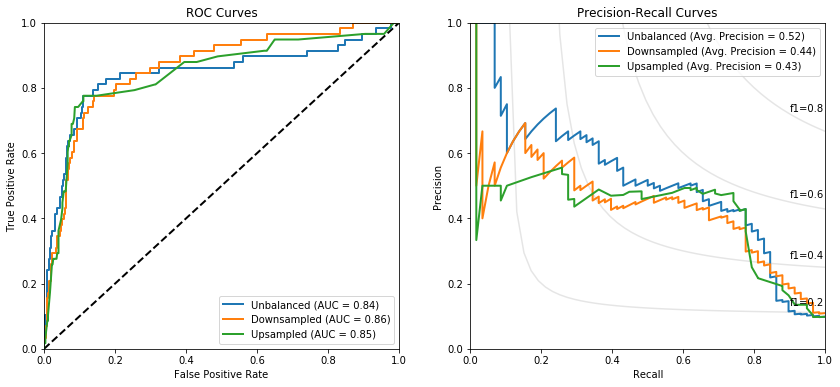

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

# Generate ROC Curves
ax1.plot([0, 1], [0, 1], linestyle='--',lw=2,color='black')
ax1.plot(fpr, tpr, lw=2, label='Unbalanced (AUC = %0.2f)' % auc)
ax1.plot(down_fpr, down_tpr, lw=2, label='Downsampled (AUC = %0.2f)' % down_auc)
ax1.plot(up_fpr, up_tpr, lw=2, label='Upsampled (AUC = %0.2f)' % up_auc)
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("ROC Curves")
ax1.legend(loc="lower right")

# Generate Precision-Recall Curves

# Include F1 score lines
f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    ax2.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    ax2.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

ax2.plot(recall, precision, lw=2, label='Unbalanced (Avg. Precision = %0.2f)' % avg_prec)
ax2.plot(down_recall, down_precision, lw=2, label='Downsampled (Avg. Precision = %0.2f)' % down_avg_prec)
ax2.plot(up_recall, up_precision, lw=2, label='Upsampled (Avg. Precision = %0.2f)' % up_avg_prec)
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("Precision-Recall Curves")
ax2.legend(loc="upper right")

### Sampling Selection
It appeared that the unbalanced model has the best performance as displayed on the Precision-Recall curves. It is likely that the upsampled model overfit to the highly repeated rows while the downsampled model generalized poorly to the test data. As a result, we will focus on establishing the best model with the original, unbalanced data set for the rest of this work. Taking a look at all of the model performances for the unbalanced samples via ROC and Precision-Recall curves.

In [47]:
# Generating values for the ROC and Precision-Recall curves

# Logistic regression model
lr_prediction = models[0]["best_model"].predict_proba(holdout_group[features])[:,1]
lr_fpr,lr_tpr,lr_thresholds = roc_curve(holdout_group[target],lr_prediction)
lr_auc = roc_auc_score(holdout_group[target],lr_prediction)
lr_precision,lr_recall,lr_thresholds2 = precision_recall_curve(holdout_group[target],lr_prediction)
lr_avg_prec = average_precision_score(holdout_group[target],lr_prediction)

# Neural network model
nn_prediction = models[1]["best_model"].predict_proba(holdout_group[features])[:,1]
nn_fpr,nn_tpr,nn_thresholds = roc_curve(holdout_group[target],nn_prediction)
nn_auc = roc_auc_score(holdout_group[target],nn_prediction)
nn_precision,nn_recall,nn_thresholds2 = precision_recall_curve(holdout_group[target],nn_prediction)
nn_avg_prec = average_precision_score(holdout_group[target],nn_prediction)

# Random Forest model
rf_prediction = models[2]["best_model"].predict_proba(holdout_group[features])[:,1]
rf_fpr,rf_tpr,rf_thresholds = roc_curve(holdout_group[target],rf_prediction)
rf_auc = roc_auc_score(holdout_group[target],rf_prediction)
rf_precision,rf_recall,rf_thresholds2 = precision_recall_curve(holdout_group[target],rf_prediction)
rf_avg_prec = average_precision_score(holdout_group[target],rf_prediction)

# SVM model
svm_prediction = models[3]["best_model"].decision_function(holdout_group[features]) #not compatible with predict_proba
svm_fpr,svm_tpr,svm_thresholds = roc_curve(holdout_group[target],svm_prediction)
svm_auc = roc_auc_score(holdout_group[target],svm_prediction)
svm_precision,svm_recall,svm_thresholds2 = precision_recall_curve(holdout_group[target],svm_prediction)
svm_avg_prec = average_precision_score(holdout_group[target],svm_prediction)

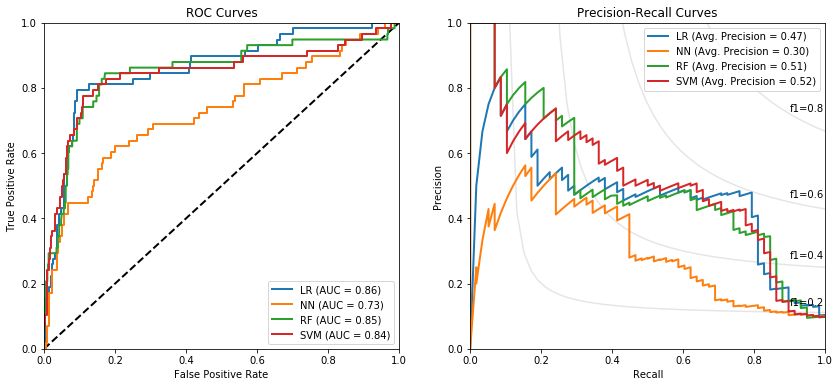

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

# Generate ROC Curves
ax1.plot([0, 1], [0, 1], linestyle='--',lw=2,color='black')
ax1.plot(lr_fpr, lr_tpr, lw=2, label='LR (AUC = %0.2f)' % lr_auc)
ax1.plot(nn_fpr, nn_tpr, lw=2, label='NN (AUC = %0.2f)' % nn_auc)
ax1.plot(rf_fpr, rf_tpr, lw=2, label='RF (AUC = %0.2f)' % rf_auc)
ax1.plot(svm_fpr, svm_tpr, lw=2, label='SVM (AUC = %0.2f)' % svm_auc)
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("ROC Curves")
ax1.legend(loc="lower right")

# Generate Precision-Recall Curves

f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    ax2.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    ax2.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

ax2.plot(lr_recall, lr_precision, lw=2, label='LR (Avg. Precision = %0.2f)' % lr_avg_prec)
ax2.plot(nn_recall, nn_precision, lw=2, label='NN (Avg. Precision = %0.2f)' % nn_avg_prec)
ax2.plot(rf_recall, rf_precision, lw=2, label='RF (Avg. Precision = %0.2f)' % rf_avg_prec)
ax2.plot(svm_recall, svm_precision, lw=2, label='SVM (Avg. Precision = %0.2f)' % svm_avg_prec)
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("Precision-Recall Curves")
ax2.legend(loc="upper right")

The model with the best balance of precision and recall appears to be the logistic regression model, even though it has a lower average precision than the SVM model, as it achieves the highest F1 score out of all the models. Let's review this model at the point of its optimal F1 score.

In [49]:
f1 = 2*lr_precision*lr_recall/(lr_precision+lr_recall)

In [50]:
print("Best model:",models[0]["best_model"])
print("F1 score:", np.nanmax(f1))
print("Precision:", lr_precision[np.nanargmax(f1)])
print("Recall:", lr_recall[np.nanargmax(f1)])

Best model: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=True)
F1 score: 0.5974025974025974
Precision: 0.4791666666666667
Recall: 0.7931034482758621


It is noteworthy that this model incorporated balanced class weights to encourage correct classification of the majority class. This was also observed in the SVM model that had the second best performance. It appears that the use of balanced class weights and a scoring metric (F1) that accounted for imbalanced classes was superior to resampling the classes.

### Final Model Recommendation

I would recommend implementing the logistic regression model described above, as it gives the best balance of precision and recall out of all of the investigated models. This will lead to identification of customers willing to subscribe to term deposits and higher success rates in calls overall. How does this compare to the original data set?

In [51]:
holdout_group[target].mean()

0.09666666666666666

Less than 10% of callers subscribed to term deposits in the previous campaign. With our model, we estimate almost 50% of clients we call based on the model's recommendation will be amenable to subscription. On top of this, our model will detect almost 80% of clients who are willing to subscribe to term deposits.

If a higher precision is required, I would recommend switching to the optimal SVM model for the unbalanced classes. This had the highest average precision of all classes. By switching to this model, a precision of approximately 0.6 could be achieved by sacrificing recall to 0.4.